In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import os
import math
from cv2 import resize as imresize

In [3]:
def convolve(filter,mat,padding,strides):

    result = None
    filter_size = filter.shape
    mat_size = mat.shape
    if len(filter_size) == 2:
        if len(mat_size) == 3:
            channel = []
            for i in range(mat_size[-1]):
                pad_mat = np.pad(mat[:,:,i], ((padding[0], padding[1]), (padding[2], padding[3])), 'constant')
                temp = []
                for j in range(0,mat_size[0],strides[1]):
                    temp.append([])
                    for k in range(0,mat_size[1],strides[0]):
                        val = (filter*pad_mat[j*strides[1]:j*strides[1]+filter_size[0],
                                      k*strides[0]:k*strides[0]+filter_size[1]]).sum()
                        temp[-1].append(val)
                channel.append(np.array(temp))

            channel = tuple(channel)
            result = np.dstack(channel)
        elif len(mat_size) == 2:
            channel = []
            pad_mat = np.pad(mat, ((padding[0], padding[1]), (padding[2], padding[3])), 'constant')
            for j in range(0, mat_size[0], strides[1]):
                channel.append([])
                for k in range(0, mat_size[1], strides[0]):
                    val = (filter * pad_mat[j * strides[1]:j * strides[1] + filter_size[0],
                                    k * strides[0]:k * strides[0] + filter_size[1]]).sum()
                    channel[-1].append(val)


            result = np.array(channel)


    return result

In [4]:
def downsample(img,step = 2):
    return img[::step,::step]

In [5]:
def GuassianKernel(sigma , dim):
    '''
    :param sigma: Standard deviation
    :param dim: dimension(must be positive and also an odd number)
    :return: return the required Gaussian kernel.
    '''
    temp = [t - (dim/2) for t in range(dim)]
    assistant = []
    for i in range(dim):
        assistant.append(temp)
    assistant = np.array(assistant)
    temp = 2*sigma*sigma
    result = (1.0/(temp*np.pi))*np.exp(-(assistant**2+(assistant.T)**2)/temp)
    return result

In [6]:
def getDoG(img,n,sigma0,S = None,O = None):
    '''
    :param img: the original img.
    :param sigma0: sigma of the first stack of the first octave. default 1.52 for complicate reasons.
    :param n: how many stacks of feature that you wanna extract.
    :param S: how many stacks does every octave have. S must bigger than 3.
    :param k: the ratio of two adjacent stacks' scale.
    :param O: how many octaves do we have.
    :return: the DoG Pyramid
    '''
    if S == None:
        S = n + 3
    if O == None:
        O = int(np.log2(min(img.shape[0], img.shape[1]))) - 3

    k = 2 ** (1.0 / n)
    sigma = [[(k**s)*sigma0*(1<<o) for s in range(S)] for o in range(O)]
    samplePyramid = [downsample(img, 1 << o) for o in range(O)]

    GuassianPyramid = []
    for i in range(O):
        GuassianPyramid.append([])
        for j in range(S):
            dim = int(6*sigma[i][j] + 1)
            if dim % 2 == 0:
                dim += 1
            GuassianPyramid[-1].append(convolve(GuassianKernel(sigma[i][j], dim),samplePyramid[i],[dim//2,dim//2,dim//2,dim//2],[1,1]))
    DoG = [[GuassianPyramid[o][s+1] - GuassianPyramid[o][s] for s in range(S - 1)] for o in range(O)]


    return DoG,GuassianPyramid

In [7]:
def adjustLocalExtrema(DoG,o,s,x,y,contrastThreshold,edgeThreshold,sigma,n,SIFT_FIXPT_SCALE):
    SIFT_MAX_INTERP_STEPS = 5
    SIFT_IMG_BORDER = 5

    point = []

    img_scale = 1.0 / (255 * SIFT_FIXPT_SCALE)
    deriv_scale = img_scale * 0.5
    second_deriv_scale = img_scale
    cross_deriv_scale = img_scale * 0.25

    img = DoG[o][s]
    i = 0
    while i < SIFT_MAX_INTERP_STEPS:
        if s < 1 or s > n or y < SIFT_IMG_BORDER or y >= img.shape[1] - SIFT_IMG_BORDER or x < SIFT_IMG_BORDER or x >= img.shape[0] - SIFT_IMG_BORDER:
            return None,None,None,None

        img = DoG[o][s]
        prev = DoG[o][s - 1]
        next = DoG[o][s + 1]

        dD = [ (img[x,y + 1] - img[x, y - 1]) * deriv_scale,
               (img[x + 1, y] - img[x - 1, y]) * deriv_scale,
               (next[x, y] - prev[x, y]) * deriv_scale ]

        v2 = img[x, y] * 2
        dxx = (img[x, y + 1] + img[x, y - 1] - v2) * second_deriv_scale
        dyy = (img[x + 1, y] + img[x - 1, y] - v2) * second_deriv_scale
        dss = (next[x, y] + prev[x, y] - v2) * second_deriv_scale
        dxy = (img[x + 1, y + 1] - img[x + 1, y - 1] - img[x - 1, y + 1] + img[x - 1, y - 1]) * cross_deriv_scale
        dxs = (next[x, y + 1] - next[x, y - 1] - prev[x, y + 1] + prev[x, y - 1]) * cross_deriv_scale
        dys = (next[x + 1, y] - next[x - 1, y] - prev[x + 1, y] + prev[x - 1, y]) * cross_deriv_scale

        H=[ [dxx, dxy, dxs],
            [dxy, dyy, dys],
            [dxs, dys, dss]]

        X = np.matmul(np.linalg.pinv(np.array(H)),np.array(dD))

        xi = -X[2]
        xr = -X[1]
        xc = -X[0]

        if np.abs(xi) < 0.5 and np.abs(xr) < 0.5 and np.abs(xc) < 0.5:
            break

        y += int(np.round(xc))
        x += int(np.round(xr))
        s += int(np.round(xi))

        i+=1

    if i >= SIFT_MAX_INTERP_STEPS:
        return None,x,y,s
    if s < 1 or s > n or y < SIFT_IMG_BORDER or y >= img.shape[1] - SIFT_IMG_BORDER or x < SIFT_IMG_BORDER or x >= \
            img.shape[0] - SIFT_IMG_BORDER:
        return None, None, None, None


    t = (np.array(dD)).dot(np.array([xc, xr, xi]))

    contr = img[x,y] * img_scale + t * 0.5
    if np.abs( contr) * n < contrastThreshold:
        return None,x,y,s


    # 利用Hessian矩阵的迹和行列式计算主曲率的比值
    tr = dxx + dyy
    det = dxx * dyy - dxy * dxy
    if det <= 0 or tr * tr * edgeThreshold >= (edgeThreshold + 1) * (edgeThreshold + 1) * det:
        return None,x,y,s

    point.append((x + xr) * (1 << o))
    point.append((y + xc) * (1 << o))
    point.append(o + (s << 8) + (int(np.round((xi + 0.5)) * 255) << 16))
    point.append(sigma * np.power(2.0, (s + xi) / n)*(1 << o) * 2)

    return point,x,y,s

In [8]:
def GetMainDirection(img,r,c,radius,sigma,BinNum):
    expf_scale = -1.0 / (2.0 * sigma * sigma)

    X = []
    Y = []
    W = []
    temphist = []

    for i in range(BinNum):
        temphist.append(0.0)

    # 图像梯度直方图统计的像素范围
    k = 0
    for i in range(-radius,radius+1):
        y = r + i
        if y <= 0 or y >= img.shape[0] - 1:
            continue
        for j in range(-radius,radius+1):
            x = c + j
            if x <= 0 or x >= img.shape[1] - 1:
                continue

            dx = (img[y, x + 1] - img[y, x - 1])
            dy = (img[y - 1, x] - img[y + 1, x])

            X.append(dx)
            Y.append(dy)
            W.append((i * i + j * j) * expf_scale)
            k += 1


    length = k

    W = np.exp(np.array(W))
    Y = np.array(Y)
    X = np.array(X)
    Ori = np.arctan2(Y,X)*180/np.pi
    Mag = (X**2+Y**2)**0.5

    # 计算直方图的每个bin
    for k in range(length):
        bin = int(np.round((BinNum / 360.0) * Ori[k]))
        if bin >= BinNum:
            bin -= BinNum
        if bin < 0:
            bin += BinNum
        temphist[bin] += W[k] * Mag[k]

    # smooth the histogram
    # 高斯平滑
    temp = [temphist[BinNum - 1], temphist[BinNum - 2], temphist[0], temphist[1]]
    temphist.insert(0, temp[0])
    temphist.insert(0, temp[1])
    temphist.insert(len(temphist), temp[2])
    temphist.insert(len(temphist), temp[3])      # padding

    hist = []
    for i in range(BinNum):
        hist.append((temphist[i] + temphist[i+4]) * (1.0 / 16.0) + (temphist[i+1] + temphist[i+3]) * (4.0 / 16.0) + temphist[i+2] * (6.0 / 16.0))

    # 得到主方向
    maxval = max(hist)

    return maxval,hist

In [9]:
def LocateKeyPoint(DoG,sigma,GuassianPyramid,n,BinNum = 36,contrastThreshold = 0.04,edgeThreshold = 10.0):
    SIFT_ORI_SIG_FCTR = 1.52
    SIFT_ORI_RADIUS = 3 * SIFT_ORI_SIG_FCTR
    SIFT_ORI_PEAK_RATIO = 0.8

    SIFT_INT_DESCR_FCTR = 512.0
    # SIFT_FIXPT_SCALE = 48
    SIFT_FIXPT_SCALE = 1

    KeyPoints = []
    O = len(DoG)
    S = len(DoG[0])
    for o in range(O):
        for s in range(1,S-1):
            threshold = 0.5*contrastThreshold/(n*255*SIFT_FIXPT_SCALE)
            img_prev = DoG[o][s-1]
            img = DoG[o][s]
            img_next = DoG[o][s+1]
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    val = img[i,j]
                    eight_neiborhood_prev = img_prev[max(0, i - 1):min(i + 2, img_prev.shape[0]), max(0, j - 1):min(j + 2, img_prev.shape[1])]
                    eight_neiborhood = img[max(0, i - 1):min(i + 2, img.shape[0]), max(0, j - 1):min(j + 2, img.shape[1])]
                    eight_neiborhood_next = img_next[max(0, i - 1):min(i + 2, img_next.shape[0]), max(0, j - 1):min(j + 2, img_next.shape[1])]
                    if np.abs(val) > threshold and \
                        ((val > 0 and (val >= eight_neiborhood_prev).all() and (val >= eight_neiborhood).all() and (val >= eight_neiborhood_next).all())
                         or (val < 0 and (val <= eight_neiborhood_prev).all() and (val <= eight_neiborhood).all() and (val <= eight_neiborhood_next).all())):

                        point,x,y,layer = adjustLocalExtrema(DoG,o,s,i,j,contrastThreshold,edgeThreshold,sigma,n,SIFT_FIXPT_SCALE)
                        if point == None:
                            continue

                        scl_octv = point[-1]*0.5/(1 << o)
                        omax,hist = GetMainDirection(GuassianPyramid[o][layer],x,y,int(np.round(SIFT_ORI_RADIUS * scl_octv)),SIFT_ORI_SIG_FCTR * scl_octv,BinNum)
                        mag_thr = omax * SIFT_ORI_PEAK_RATIO
                        for k in range(BinNum):
                            if k > 0:
                                l = k - 1
                            else:
                                l = BinNum - 1
                            if k < BinNum - 1:
                                r2 = k + 1
                            else:
                                r2 = 0
                            if hist[k] > hist[l] and hist[k] > hist[r2] and hist[k] >= mag_thr:
                                bin = k + 0.5 * (hist[l]-hist[r2]) /(hist[l] - 2 * hist[k] + hist[r2])
                                if bin < 0:
                                    bin = BinNum + bin
                                else:
                                    if bin >= BinNum:
                                        bin = bin - BinNum
                                temp = point[:]
                                temp.append((360.0/BinNum) * bin)
                                KeyPoints.append(temp)


    return KeyPoints

In [10]:
def calcSIFTDescriptor(img,ptf,ori,scl,d,n,SIFT_DESCR_SCL_FCTR = 3.0,SIFT_DESCR_MAG_THR = 0.2,SIFT_INT_DESCR_FCTR = 512.0,FLT_EPSILON = 1.19209290E-07):
    dst = []
    pt = [int(np.round(ptf[0])), int(np.round(ptf[1]))] # 坐标点取整
    cos_t = np.cos(ori * (np.pi / 180)) # 余弦值
    sin_t = np.sin(ori * (np.pi / 180)) # 正弦值
    bins_per_rad = n / 360.0
    exp_scale = -1.0 / (d * d * 0.5)
    hist_width = SIFT_DESCR_SCL_FCTR * scl
    radius = int(np.round(hist_width * 1.4142135623730951 * (d + 1) * 0.5))
    cos_t /= hist_width
    sin_t /= hist_width

    rows = img.shape[0]
    cols = img.shape[1]


    hist = [0.0]*((d+2)*(d+2)*(n+2))
    X = []
    Y = []
    RBin = []
    CBin = []
    W = []

    k = 0
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):

            c_rot = j * cos_t - i * sin_t
            r_rot = j * sin_t + i * cos_t
            rbin = r_rot + d / 2 - 0.5
            cbin = c_rot + d / 2 - 0.5
            r = pt[1] + i
            c = pt[0] + j

            if rbin > -1 and rbin < d and cbin > -1 and cbin < d and r > 0 and r < rows - 1 and c > 0 and c < cols - 1:
                dx = (img[r, c+1] - img[r, c-1])
                dy = (img[r-1, c] - img[r+1, c])
                X.append(dx)
                Y.append(dy)
                RBin.append(rbin)
                CBin.append(cbin)
                W.append((c_rot * c_rot + r_rot * r_rot) * exp_scale)
                k+=1

    length = k
    Y = np.array(Y)
    X = np.array(X)
    Ori = np.arctan2(Y,X)*180/np.pi
    Mag = (X ** 2 + Y ** 2) ** 0.5
    W = np.exp(np.array(W))

    for k in range(length):
        rbin = RBin[k]
        cbin = CBin[k]
        obin = (Ori[k] - ori) * bins_per_rad
        mag = Mag[k] * W[k]

        r0 = int(rbin)
        c0 = int(cbin)
        o0 = int(obin)
        rbin -= r0
        cbin -= c0
        obin -= o0

        if o0 < 0:
            o0 += n
        if o0 >= n:
            o0 -= n

        # histogram update using tri-linear interpolation
        v_r1 = mag * rbin
        v_r0 = mag - v_r1

        v_rc11 = v_r1 * cbin
        v_rc10 = v_r1 - v_rc11

        v_rc01 = v_r0 * cbin
        v_rc00 = v_r0 - v_rc01

        v_rco111 = v_rc11 * obin
        v_rco110 = v_rc11 - v_rco111

        v_rco101 = v_rc10 * obin
        v_rco100 = v_rc10 - v_rco101

        v_rco011 = v_rc01 * obin
        v_rco010 = v_rc01 - v_rco011

        v_rco001 = v_rc00 * obin
        v_rco000 = v_rc00 - v_rco001

        idx = ((r0 + 1) * (d + 2) + c0 + 1) * (n + 2) + o0
        hist[idx] += v_rco000
        hist[idx+1] += v_rco001
        hist[idx + (n+2)] += v_rco010
        hist[idx + (n+3)] += v_rco011
        hist[idx+(d+2) * (n+2)] += v_rco100
        hist[idx+(d+2) * (n+2)+1] += v_rco101
        hist[idx+(d+3) * (n+2)] += v_rco110
        hist[idx+(d+3) * (n+2)+1] += v_rco111

    # finalize histogram, since the orientation histograms are circular
    for i in range(d):
        for j in range(d):
            idx = ((i+1) * (d+2) + (j+1)) * (n+2)
            hist[idx] += hist[idx+n]
            hist[idx+1] += hist[idx+n+1]
            for k in range(n):
                dst.append(hist[idx+k])

    # copy histogram to the descriptor,
    # apply hysteresis thresholding
    # and scale the result, so that it can be easily converted
    # to byte array
    nrm2 = 0
    length = d * d * n
    for k in range(length):
        nrm2 += dst[k] * dst[k]
    thr = np.sqrt(nrm2) * SIFT_DESCR_MAG_THR

    nrm2 = 0
    for i in range(length):
        val = min(dst[i], thr)
        dst[i] = val
        nrm2 += val * val
    nrm2 = SIFT_INT_DESCR_FCTR / max(np.sqrt(nrm2), FLT_EPSILON)
    for k in range(length):
        dst[k] = min(max(dst[k] * nrm2,0),255)

    return dst

In [11]:
def calcDescriptors(gpyr,keypoints,SIFT_DESCR_WIDTH = 4,SIFT_DESCR_HIST_BINS = 8):
    # SIFT_DESCR_WIDTH = 4，描述直方图的宽度
    # SIFT_DESCR_HIST_BINS = 8
    d = SIFT_DESCR_WIDTH
    n = SIFT_DESCR_HIST_BINS
    descriptors = []

    for i in range(len(keypoints)):
        kpt = keypoints[i]
        o = kpt[2] & 255
        s = (kpt[2] >> 8) & 255 # 该特征点所在的组序号和层序号
        scale = 1.0 / (1 << o)  # 缩放倍数
        size = kpt[3] * scale # 该特征点所在组的图像尺寸
        ptf = [kpt[1] * scale, kpt[0] * scale] # 该特征点在金字塔组中的坐标
        img = gpyr[o][s] # 该点所在的金字塔图像

        descriptors.append(calcSIFTDescriptor(img, ptf, kpt[-1], size * 0.5, d, n))
    return descriptors

In [12]:
def SIFT(img,showDoGimgs = False):
    SIFT_SIGMA = 1.6
    SIFT_INIT_SIGMA = 0.5 # 假设的摄像头的尺度
    sigma0 = np.sqrt(SIFT_SIGMA**2-SIFT_INIT_SIGMA**2)

    n = 3

    DoG,GuassianPyramid = getDoG(img, n,sigma0)
    if showDoGimgs:
        for i in DoG:
            for j in i:
                plt.imshow(j.astype(np.uint8), cmap='gray')
                plt.axis('off')
                plt.show()

    KeyPoints = LocateKeyPoint(DoG, SIFT_SIGMA, GuassianPyramid, n)
    discriptors = calcDescriptors(GuassianPyramid,KeyPoints)

    return KeyPoints,discriptors

In [13]:
def Lines(img,info,color = (255,0,0),err = 700):

    if len(img.shape) == 2:
        result = np.dstack((img,img,img))
    else:
        result = img
    k = 0
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            temp = (info[:,1]-info[:,0])
            A = (j - info[:,0])*(info[:,3]-info[:,2])
            B = (i - info[:,2])*(info[:,1]-info[:,0])
            temp[temp == 0] = 1e-9
            t = (j-info[:,0])/temp
            e = np.abs(A-B)
            temp = e < err
            if (temp*(t >= 0)*(t <= 1)).any():
                result[i,j] = color
                k+=1
    print(k)

    return result

In [14]:
def drawLines(X1,X2,Y1,Y2,dis,img,num = 10):

    info = list(np.dstack((X1,X2,Y1,Y2,dis))[0])
    info = sorted(info,key=lambda x:x[-1])
    info = np.array(info)
    info = info[:min(num,info.shape[0]),:]
    img = Lines(img,info)
    #plt.imsave('./sift/3.jpg', img)

    if len(img.shape) == 2:
        plt.imshow(img.astype(np.uint8),cmap='gray')
    else:
        plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    #plt.plot([info[:,0], info[:,1]], [info[:,2], info[:,3]], 'c')
    # fig = plt.gcf()
    # fig.set_size_inches(int(img.shape[0]/100.0),int(img.shape[1]/100.0))
    #plt.savefig('./sift/2.jpg')
    plt.show()

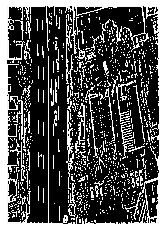

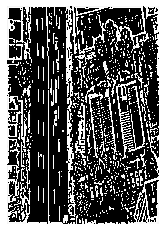

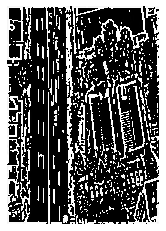

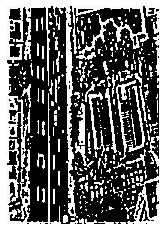

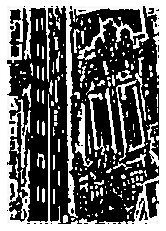

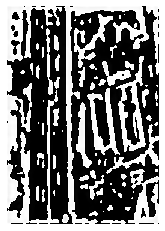

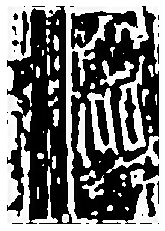

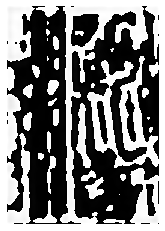

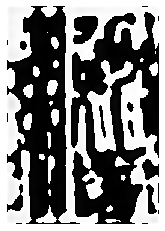

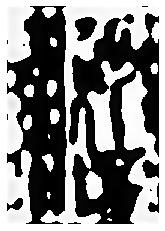

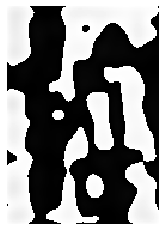

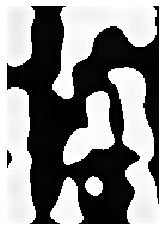

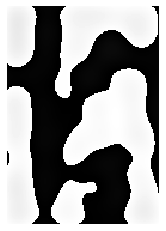

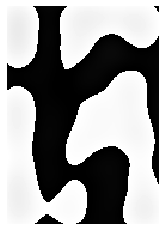

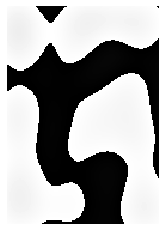

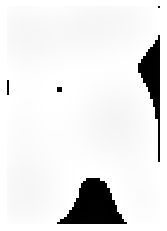

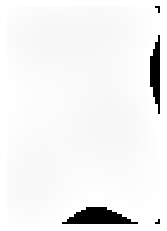

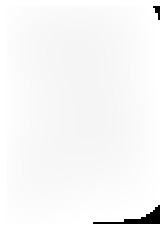

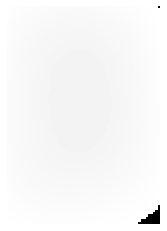

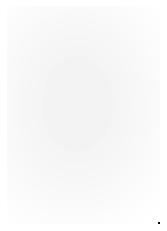

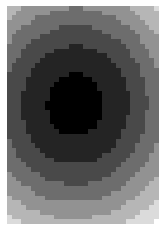

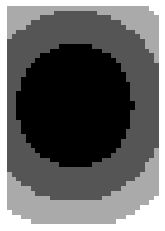

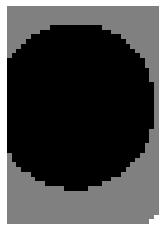

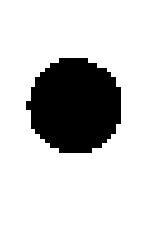

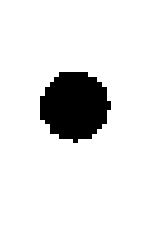

12388


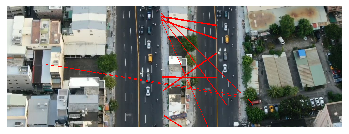

In [15]:
if __name__ == '__main__':
    origimg = plt.imread('1.jpg')
    if len(origimg.shape) ==  3:
        img = origimg.mean(axis=-1)
    else:
        img = origimg
    keyPoints,discriptors = SIFT(img)


    origimg2 = plt.imread('2.jpg')
    if len(origimg.shape) == 3:
        img2 = origimg2.mean(axis=-1)
    else:
        img2 = origimg2
    ScaleRatio = img.shape[0]*1.0/img2.shape[0]
    img2 = imresize(img2,(img.shape[0],int(round(ScaleRatio*img2.shape[1]))))
    keyPoints2, discriptors2 = SIFT(img2,True)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(discriptors,[0]*len(discriptors))
    match = knn.kneighbors(discriptors2,n_neighbors=1,return_distance=True)

    keyPoints = np.array(keyPoints)[:,:2]
    keyPoints2 = np.array(keyPoints2)[:,:2]

    keyPoints2[:, 1] = img.shape[1] + keyPoints2[:, 1]

    origimg2 = imresize(origimg2,img2.shape)
    result = np.hstack((origimg,origimg2))

    keyPoints = keyPoints[match[1][:,0]]

    X1 = keyPoints[:, 1]
    X2 = keyPoints2[:, 1]
    Y1 = keyPoints[:, 0]
    Y2 = keyPoints2[:, 0]

    drawLines(X1,X2,Y1,Y2,match[0][:,0],result)